In [43]:
"""
Cross entropy benchmarking of two qubits (XEB) is a method for characterizing the fidelity of a two-qubit gate.
The XEB sequence consists of a random sequence of single-qubit gates and a two-qubit gate, followed by a measurement.
The sequence is repeated many times, and the results are used to calculate the cross entropy between the ideal and measured states.
The cross entropy is a measure of the distance between two probability distributions, and is related to the fidelity of the two-qubit gate.
The cross entropy is calculated as follows:
    1. The ideal state is calculated by applying the sequence of single-qubit gates and the two-qubit gate to the initial state |00>.
    2. The measured state is calculated by applying the sequence of single-qubit gates to the initial state |00>, followed by a measurement.
    3. The cross entropy is calculated between the ideal and measured states.
The cross entropy is calculated for a range of sequence depths, and the results are used to calculate the fidelity of the two-qubit gate.
In this script, we provide an example of how to run an XEB sequence on the OPX.

Author: Arthur Strauss - Quantum Machines
Created: 16/01/2024 (Last modified: 16/01/2024)
"""
import numpy as np
import pandas as pd
import seaborn as sns
from qm import QuantumMachinesManager
from qm.qua import *
from qm.simulate.credentials import create_credentials
from scipy.optimize import curve_fit

import sys
sys.path.append('/Users/adamachuck/Documents/GitHub/PYQUM/TEST/BETAsite/QM/OPXPlus/Configurations')

from configuration import *
from qm.simulate import SimulationConfig
from matplotlib import pyplot as plt
import pprint
from macros import multiplexed_readout, qua_declaration, cz_gate
from qiskit import QuantumCircuit
from qiskit.circuit.library import CZGate, RXGate, RYGate, RZGate, HGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate
from qiskit.quantum_info import Statevector
from time import sleep

import warnings

%matplotlib inline


In [44]:
qubits = [4, 5]
qubits_el = [f"q{i}_xy" for i in qubits]
multiplexed = [4, 5, 1, 2, 3]
# multiplexed = [1, 2, 3, 4, 5]
cz_type = "const_wf"
apply_cz = True
impose_0_cycle = True

seqs = 7  # 101 # Number of random sequences to run per depth
max_depth = 2  # 7  # Max depth of the XEB sequence
step = 1  # Step for the depth iteration
avgs = 77  # 101  # Number of averages per sequence
depths = np.arange(1, max_depth+1, step)  # Create an array of depths to iterate through

time_per_point = 15/(101*37*101) # in min
print(f"Estimated runtime: {seqs*avgs*len(depths)*time_per_point} minutes")

Estimated runtime: 0.04284158680786462 minutes


In [52]:
# Random gates
X90, Y90, Z180 = RXGate(np.pi / 2), RYGate(np.pi / 2), RZGate(np.pi)
Z45 = RZGate(1 * np.pi / 4)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
W = UnitaryGate((X.to_matrix() + Y.to_matrix())/np.sqrt(2), label='W')
SW = UnitaryGate((np.sqrt((X.to_matrix() + Y.to_matrix())/np.sqrt(2))), label='SW')

XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
# XY90 = UnitaryGate((T.to_matrix() @ X90.to_matrix()), label="XY90")
# XY90 = UnitaryGate((X90.to_matrix() @ T.to_matrix()), label="XY90")

XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
CZ, CP = CZGate(), CPhaseGate(np.pi/2)

X90_dict = {"gate": X90, 'amp_matrix': np.array([1., 0., 0., 1.])}
# Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., 1., -1., 0.])}
Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., -1., 1., 0.])} # verified w/ CX
# XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., 1., -1., 1.])}
XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])} # verified w/ CX

# TODO: For the dicts below, need to check the validity of amplitude matrices!
XY90mm_dict = {"gate": XY90mm, 'amp_matrix': 0.70710678 * np.array([-1., -1., 1., -1.])}
XY90pm_dict = {"gate": XY90pm, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])}
XY90mp_dict = {"gate": XY90mp, 'amp_matrix': 0.70710678 * np.array([-1., 1., -1., 1.])}
T_dict = {"gate": T, 'amp_matrix': np.array([1., 0., 0., 1])}  # No actual need for amp_matrix,
# but here for consistency with the current workflow
SW_dict = {"gate": SW, 'amp_matrix': np.array([1., 0., 0., 1.])}  # WARNING: Amp matrix not correct, need to think
# abour how to implement it

# Possible gate sets
gate_dict1 = {0: X90_dict, 1: Y90_dict, 2: T_dict}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90_dict, 1: Y90_dict, 2: SW_dict}  # Supremacy gate set (https://www.nature.com/articles/s41586-019-1666-5)
gate_dict3 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict, 3: XY90mm_dict, 4: XY90pm_dict, 5: XY90mp_dict}  # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict}  # Currently used in the QM XEB example (XY90==XY90pp)
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]

# Choose the gate set
gate_set_choice = 3  # 1, 2, 3 or 4

gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)


In [36]:
# Check Unitary:
from qiskit.quantum_info import Operator

Operator(XY90).is_unitary()
print(XY90.to_matrix()@XY90.to_matrix().conjugate().transpose())

# print(XY90pm.to_matrix())
# print(W.to_matrix())

print((SW.to_matrix() @ SW.to_matrix()))
print(np.sqrt(W.to_matrix()))
# print((Y90.to_matrix() @ Z180.to_matrix()))

print(np.sqrt(1j))

# from Supremacy's paper:
sw = UnitaryGate(np.array([[1, -np.sqrt(1j)], [np.sqrt(-1j), 1]])/np.sqrt(2))
w = sw.to_matrix() @ sw.to_matrix()
print(f"Supremacy W:\n {w}")

# print(XY90.to_matrix())
W = UnitaryGate((X.to_matrix() + Y.to_matrix())/np.sqrt(2), label='W')

from scipy.linalg import sqrtm
SW = UnitaryGate((sqrtm(W.to_matrix())), label='SW')
print(f"SW**2:\n {SW.to_matrix() @ SW.to_matrix()}")

print(f"W:\n {W.to_matrix()}")

# w = w.to_matrix()
W = W.to_matrix()
T = T.to_matrix()
print(np.array_equal(np.round(w,5), np.round(W,5)))

[[ 1.0000000e+00-9.95716912e-18j -9.7278522e-18-9.72785220e-18j]
 [-9.7278522e-18+9.72785220e-18j  1.0000000e+00+9.95716912e-18j]]
[[4.74800169e-16-3.75731123e-16j 7.07106781e-01-7.07106781e-01j]
 [7.07106781e-01+7.07106781e-01j 6.66133815e-16+8.32667268e-17j]]
[[0.        +0.j         0.92387953-0.38268343j]
 [0.92387953+0.38268343j 0.        +0.j        ]]
(0.7071067811865476+0.7071067811865475j)
Supremacy W:
 [[ 0.00000000e+00+1.11022302e-16j -7.07106781e-01-7.07106781e-01j]
 [ 7.07106781e-01-7.07106781e-01j  2.23711432e-17+1.11022302e-16j]]
SW**2:
 [[4.74800169e-16-3.75731123e-16j 7.07106781e-01-7.07106781e-01j]
 [7.07106781e-01+7.07106781e-01j 6.66133815e-16+8.32667268e-17j]]
W:
 [[0.        +0.j         0.70710678-0.70710678j]
 [0.70710678+0.70710678j 0.        +0.j        ]]
False


In [53]:
qmm = QuantumMachinesManager(host=qop_ip, port=qop_port, cluster_name=cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(host="tyler-263ed49e.dev.quantum-machines.co", port=443, credentials=create_credentials())
# qubits = ["q0", "q1"]  # Fix which qubits to use on the chip (quantum elements in the configuration)
# readout_elements = ["rr0", "rr1"]  # Fix which readout resonators to use on the chip (readout elements in the
# configuration)
# ge_threshold = 0.1  # Threshold for the ground state population (used for the readout)
# thermalization_time = 100  # Thermalization time for the qubits (in ns)
simulate = False

def assign_amplitude_matrix(gate, a):
    """
    QUA Macro for assigning the amplitude matrix arguments for a given gate index.
    :param gate: Gate index
    :param a: Amplitude matrix arguments
    """
    with switch_(gate):
        for i in range(random_gates):
            with case_(i):
                for j in range(4):
                    assign(a[j], gate_dict[i]['amp_matrix'][j])


# QUA Program

with program() as xeb:
    # Declare QUA variables
    I, I_st, Q, Q_st, n, n_st = qua_declaration(nb_of_qubits=len(multiplexed))
    # I, Q = [declare(fixed) for _ in range(2)], [declare(fixed) for _ in range(2)]
    s, tot_state_ = declare(int), declare(int)
    d, d_ = declare(int), declare(int)
    g = [declare(int, size=max_depth) for _ in range(2)]  # Gate indices list for both qubits
    a = [[declare(fixed, size=max_depth) for _ in range(4)] for _ in
         range(len(qubits))]  # Amplitude matrices for both qubits (for all depths)
    counts = [declare(int, value=0) for _ in range(2 ** len(qubits))] # Counts for the 4 possible states
    state = [declare(bool) for _ in range(len(multiplexed))] # State of the qubits
    # Declare streams
    # I_st, Q_st = [declare_stream() for _ in range(2)], [declare_stream() for _ in range(2)]
    s_st = declare_stream()
    counts_st = [declare_stream() for _ in range(4)]
    state_st = [declare_stream() for _ in range(len(multiplexed))]
    g_st = [declare_stream() for _ in range(len(qubits))]

    # Randomize the random number generator
    r = Random()
    r.set_seed(12321)
    # r.set_seed(11111)

    # If we are simulating, we need to update the frequency of the qubits to 0 to visualize the sequence
    # if simulate:
    if True:
        a_st = [[declare_stream() for _ in range(4)] for _ in range(len(qubits))]
        # for qubit in qubits_el:
            # update_frequency(qubit, 0)

    # Generate and run the XEB sequences
    with for_(s, 0, s < seqs, s + 1):
        with for_each_(d, depths): # max-depths
            # Randomize the sequence of single-qubit gates
            with for_(d_, 0, d_ < d, d_ + 1):
                for q in range(len(qubits)):
                    assign(g[q][d_], r.rand_int(random_gates)) # different from Google: randomizing for each growing-depths and sequences
                    with if_(d_ > 0):
                        with while_(g[q][d_] == g[q][d_ - 1]):  # Make sure the same gate is not applied twice in a row
                            assign(g[q][d_], r.rand_int(random_gates))
                    # Map the sequence indices into amplitude matrix arguments (each index corresponds to a random gate)
                    assign_amplitude_matrix(g[q][d_], [a[q][i][d_] for i in range(4)])
                    save(g[q][d_], g_st[q])

                    # if simulate:
                    if True:
                        for amp_matrix_element in range(4):
                            save(a[q][amp_matrix_element][d_], a_st[q][amp_matrix_element])

            # Run the XEB sequence
            with for_(n, 0, n < avgs, n + 1):
                # save(n, n_st)
                # Reset the qubits to their ground states (here simple wait but could be an active reset macro)
                if simulate:
                    wait(25, *qubits_el)
                else:
                    wait(3 * thermalization_time, *qubits_el)

                # NOTE: imposing first gate at 0-cycle:
                if impose_0_cycle:
                    for q in range(2): 
                        play("x90" * amp(*XY90_dict["amp_matrix"]), qubits_el[q])
                        # play("y90", qubits_el[q])
                        # play("x180", qubits_el[q])

                # Play all cycles generated for sequence s of depth d
                with for_(d_, 0, d_ < d, d_ + 1):
                    for q in range(2):  # Play single qubit gates on both qubits
                        if T_dict in gate_dict.values():
                            with switch_(g[q][d_], unsafe=True):
                                for j in range(2):
                                    with case_(j):
                                        play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                                with case_(2):
                                    frame_rotation(np.pi/4, qubits_el[q])
                        elif SW_dict in gate_dict.values():
                            # raise NotImplementedError("SW gate not readily implemented yet")
                            warnings.warn("SW gate not readily implemented yet")
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                        else:
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                    align()
                    if apply_cz:
                        # Insert your two-qubit gate macro here
                        cz_gate(qubits[0], qubits[1], cz_type)
                        frame_rotation_2pi(eval(f"cz{5}_{4}_2pi_dev"), "q5_xy")
                        frame_rotation_2pi(eval(f"cz{4}_{5}_2pi_dev"), "q4_xy")
                    align()

                # Measure the state (insert your readout macro here)
                multiplexed_readout(I, I_st, Q, Q_st, resonators=multiplexed, weights="rotated_")

                # State discrimination
                assign(state[0], I[0] > eval(f"ge_threshold_q{qubits[0]}"))
                assign(state[1], I[1] > eval(f"ge_threshold_q{qubits[1]}"))
                save(state[0], state_st[0])
                save(state[1], state_st[1])

                # State Estimation: returned as an integer, to be later converted to bitstrings
                assign(tot_state_, Cast.to_int(state[0]) + 2 * Cast.to_int(state[1]))
                # assign(tot_state_, Cast.to_int(state[1]) + 2 * Cast.to_int(state[0]))
                with switch_(tot_state_):
                    for i in range(2 ** len(qubits)):  # Bitstring conversion
                        with case_(i):
                            assign(counts[i], counts[i] + 1)  # counts for 00, 01, 10 and 11
            
            for i in range(2 ** len(qubits)):  # Resetting Bitstring collection
                save(counts[i], counts_st[i])
                assign(counts[i], 0)

            # Save the sequence iteration to get the progress bar
            save(s, s_st)

    # Save the results
    with stream_processing():
        s_st.save("s")
        for i in range(2):
            g_st[i].save_all(f"g{i + 1}")
            I_st[i].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"I{i + 1}")
            Q_st[i].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"Q{i + 1}")
            state_st[i].boolean_to_int().buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(
                f"state{i + 1}")
        for i in range(4):
            string = "s" + bin(i)[2:].zfill(2)
            counts_st[i].buffer(len(depths)).save_all(string)

        # if simulate:
        if True:
            for i in range(2):
                for d_ in range(4):
                    a_st[i][d_].save_all(f"a{i + 1}_{bin(d_)[2:]}")

if simulate:
    job = qmm.simulate(config, xeb, SimulationConfig(15000))
    job.get_simulated_samples().con1.plot()
    job.get_simulated_samples().con2.plot()
    plt.show()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(xeb)

job.result_handles.wait_for_all_values()
g = [job.result_handles.get(f"g{i}").fetch_all()['value'] for i in [1, 2]]

if simulate:
    a1_00, a1_01, a1_10, a1_11 = [job.result_handles.get(f"a1_{bin(i)[2:]}").fetch_all()['value'].flatten() for i in
                                  range(4)]
    a2_00, a2_01, a2_10, a2_11 = [job.result_handles.get(f"a2_{bin(i)[2:]}").fetch_all()['value'].flatten() for i in
                                  range(4)]
else:
    a1_00, a1_01, a1_10, a1_11 = [job.result_handles.get(f"a1_{bin(i)[2:]}").fetch_all()['value'].flatten() for i in
                                  range(4)]
    a2_00, a2_01, a2_10, a2_11 = [job.result_handles.get(f"a2_{bin(i)[2:]}").fetch_all()['value'].flatten() for i in
                                  range(4)]

    I1, I2, Q1, Q2 = [job.result_handles.get(f"{i}{j}").fetch_all()['value'] for i in ["I", "Q"] for j in [1, 2]]

    state1, state2 = [job.result_handles.get(f'state{i}').fetch_all()['value'] for i in [1, 2]]
    state00, state01, state10, state11 = [job.result_handles.get(f's{bin(i)[2:].zfill(2)}').fetch_all()['value'] for
                                          i in
                                          range(4)]
    
    print(f"state1:\n {state1}, state2:\n {state2}")
    print(f"state00:\n {state00}, state01:\n {state01}, state10:\n {state10}, state11:\n {state11}")

    S1 = I1 + 1J * Q1
    S2 = I2 + 1J * Q2

    # Close the quantum machines at the end in order to put all flux biases to 0 so that the fridge doesn't heat-up
    qm.close()

    

2024-02-16 17:12:09,932 - qm - INFO     - Performing health check
2024-02-16 17:12:09,953 - qm - INFO     - Health check passed
2024-02-16 17:12:11,654 - qm - INFO     - Sending program to QOP for compilation
2024-02-16 17:12:13,086 - qm - INFO     - Executing program
state1:
 [[0.88311688 0.5974026 ]
 [0.8961039  0.76623377]
 [0.87012987 0.72727273]
 [0.92207792 0.68831169]
 [0.83116883 0.71428571]
 [0.90909091 0.77922078]
 [0.8961039  0.57142857]], state2:
 [[0.94805195 0.51948052]
 [0.83116883 0.53246753]
 [0.14285714 0.37662338]
 [0.42857143 0.45454545]
 [0.8961039  0.44155844]
 [0.12987013 0.48051948]
 [0.55844156 0.64935065]]
state00:
 [[ 0 14]
 [ 2 15]
 [10 13]
 [ 2 14]
 [ 0 11]
 [ 6 15]
 [ 4 15]], state01:
 [[ 4 23]
 [11 21]
 [56 35]
 [42 28]
 [ 8 32]
 [61 25]
 [30 12]], state10:
 [[ 9 17]
 [ 6  3]
 [ 0  8]
 [ 4 10]
 [13 11]
 [ 1  2]
 [ 4 18]], state11:
 [[64 23]
 [58 38]
 [11 21]
 [29 25]
 [56 23]
 [ 9 35]
 [39 32]]


In [129]:
# Process results (Post-processing)

# Rebuild gate sequences generated from the QUA:
sq_indices = []
idx = 0
for s in range(seqs):
    sq_indices.append([])
    for i, d in enumerate(depths):
        sq_indices[s].append(np.zeros((len(qubits), d), dtype=int))
        for d_ in range(d):
            for q in range(len(qubits)):
                sq_indices[s][i][q][d_] = g[q][idx]
            idx += 1


def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

records = []
incoherent_distribution = np.ones(2 ** len(qubits)) / (2 ** len(qubits))
fidelities = np.zeros((seqs, len(depths)))
expected_probs = np.zeros((seqs, len(depths), 2 ** len(qubits)))
measured_probs = np.zeros((seqs, len(depths), 2 ** len(qubits)))

# Reconstruct every Circuit from the previously rebuilt gate sequences: (using Qiskit)
circuits_list = []
singularity = []
for s in range(seqs):
    circuits_list.append([])
    for d_, d in enumerate(depths):
        state = Statevector.from_int(0, 2 ** len(qubits))
        qc = QuantumCircuit(len(qubits))

        # NOTE: imposing first gate at 0-cycle:
        gate_cycle_0 = XY90 # XY90, H
        if impose_0_cycle:
            qc.append(gate_cycle_0, [0]) 
            qc.append(gate_cycle_0, [1])

        for k in range(d):
            sq_gates = [gate_dict[sq_indices[s][d_][q][k]]["gate"] for q in range(len(qubits))]
            for q in range(len(qubits)):
                qc.append(sq_gates[q], [q])

            if apply_cz: 
                qc.append(CZ, [0, 1])

        circuits_list[s].append(qc)
        expected_probs[s, d_] = np.round(Statevector(qc).probabilities(), 5) # [1, 0]
        measured_probs[s, d_] = np.array([state00[s][d_], state01[s][d_],
                                            state10[s][d_], state11[s][d_]]) / avgs

        xe_incoherent = cross_entropy(incoherent_distribution, expected_probs[s, d_])
        xe_measured = cross_entropy(measured_probs[s, d_], expected_probs[s, d_])
        xe_expected = cross_entropy(expected_probs[s, d_], expected_probs[s, d_])

        f_xeb = ((xe_incoherent - xe_measured) / (xe_incoherent - xe_expected))
        fidelities[s, d_] = f_xeb

        # NOTE: checking singularities:
        if np.isnan(f_xeb) or np.isinf(f_xeb):
            print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
            fidelities[s, d_] = 0
            singularity.append((s, d_))
        else:
            pass
            # print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            # print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
        
        records += [
        {
            "sequence": s,
            "depth": depths[d_],
            "pure_probs": expected_probs[s, d_],
            "sampled_probs": measured_probs[s, d_],
            "circuit": circuits_list[s][d_],
        }
    ]
        
print(f"singularities: {singularity}")
print(f"overall singularities: {len(singularity)/seqs/len(depths)*100}%")

for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / 2 ** len(qubits)
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)


singularities: []
overall singularities: 0.0%


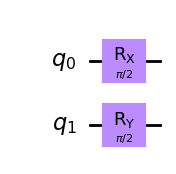

In [13]:
# # Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
# for s, d_ in singularity[0:2]:
    # print(s, d_)
circuits_list[0][0].draw("mpl", style="clifford")
# print(circuits_list[s][d_])

In [130]:
for s, d_ in singularity:
    print(expected_probs[s, d_])

In [131]:
idx = 0
print("seqs: %s, depths: %s" %(seqs, depths))
for s in range(seqs):
    for id, d in enumerate(depths):
        print("circuit of seqs-%s, depths-%s:\n %s" %(s+1, d, circuits_list[s][id]))
        for d_ in range(d):
            print(f"cycle-{d_+1}")
            print(f"a1:\n [[{a1_00[idx]}, {a1_01[idx]}], [{a1_10[idx]}, {a1_11[idx]}]]")
            print(f"a2:\n [[{a2_00[idx]}, {a2_01[idx]}], [{a2_10[idx]}, {a2_11[idx]}]]")
            idx += 1

seqs: 77, depths: [1 2 3 4 5 6 7]
circuit of seqs-1, depths-1:
      ┌──────┐┌─────────┐   
q_0: ┤ XY90 ├┤ Rx(π/2) ├─■─
     ├──────┤├─────────┤ │ 
q_1: ┤ XY90 ├┤ Ry(π/2) ├─■─
     └──────┘└─────────┘   
cycle-1
a1:
 [[1.0, 0.0], [0.0, 1.0]]
a2:
 [[0.0, -1.0], [1.0, 0.0]]
circuit of seqs-1, depths-2:
      ┌──────┐┌─────────┐     ┌──────┐    
q_0: ┤ XY90 ├┤ Rx(π/2) ├─■───┤ XY90 ├──■─
     ├──────┤└─┬──────┬┘ │ ┌─┴──────┴┐ │ 
q_1: ┤ XY90 ├──┤ XY90 ├──■─┤ Ry(π/2) ├─■─
     └──────┘  └──────┘    └─────────┘   
cycle-1
a1:
 [[1.0, 0.0], [0.0, 1.0]]
a2:
 [[0.7071067802608013, -0.7071067802608013], [0.7071067802608013, 0.7071067802608013]]
cycle-2
a1:
 [[0.7071067802608013, -0.7071067802608013], [0.7071067802608013, 0.7071067802608013]]
a2:
 [[0.0, -1.0], [1.0, 0.0]]
circuit of seqs-1, depths-3:
      ┌──────┐┌─────────┐   ┌──────┐   ┌─────────┐   
q_0: ┤ XY90 ├┤ Ry(π/2) ├─■─┤ XY90 ├─■─┤ Ry(π/2) ├─■─
     ├──────┤├─────────┤ │ ├──────┤ │ ├─────────┤ │ 
q_1: ┤ XY90 ├┤ Rx(π/2) ├─■─┤ XY90 ├─■─┤

<00> Measured
data: [[0.03603604 0.17760618 0.1956242  0.08108108 0.08494208 0.11711712
  0.08622909]
 [0.02059202 0.21106821 0.14543115 0.15701416 0.1016731  0.0952381
  0.13127413]
 [0.02831403 0.21492921 0.17374517 0.07979408 0.07335907 0.15701416
  0.11840412]
 [0.01930502 0.1956242  0.24581725 0.05019305 0.05534106 0.11454311
  0.18532819]
 [0.02059202 0.24066924 0.2020592  0.18018018 0.07850708 0.17760618
  0.07335907]
 [0.01930502 0.18661519 0.13513514 0.19047619 0.11711712 0.10553411
  0.07593308]
 [0.03732304 0.22651223 0.11583012 0.05405405 0.11325611 0.12355212
  0.10682111]
 [0.01673102 0.14028314 0.1981982  0.12483912 0.12097812 0.06821107
  0.08880309]
 [0.01415701 0.21235521 0.1003861  0.16473616 0.14671815 0.07593308
  0.05276705]
 [0.01415701 0.22908623 0.16087516 0.26126126 0.14671815 0.14414414
  0.18661519]
 [0.01415701 0.1969112  0.22908623 0.10553411 0.09137709 0.23037323
  0.0978121 ]
 [0.00772201 0.2020592  0.08365508 0.14929215 0.04890605 0.08236808
  0.1467181

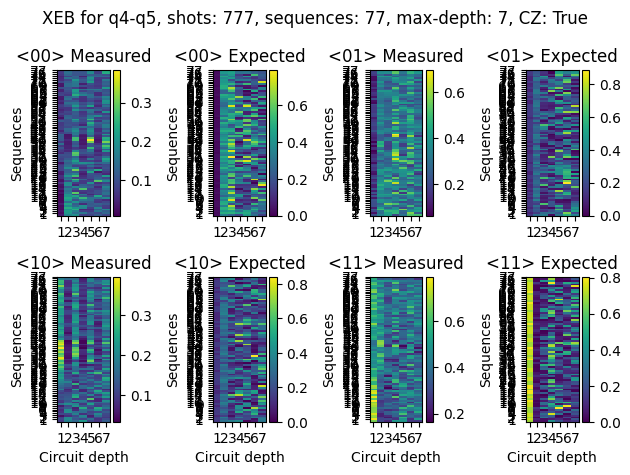

In [132]:

# Plot the results
def create_subplot(data, subplot_number, title):
    print(title)
    print("data: %s" % data)
    print(subplot_number)
    plt.subplot(subplot_number)
    # plt.pcolor(depths, range(seqs), np.abs(data), vmin=0., vmax=1.)
    plt.pcolor(depths, range(seqs), np.abs(data))
    ax = plt.gca()
    ax.set_title(title)
    if subplot_number > 244: ax.set_xlabel('Circuit depth')
    ax.set_ylabel('Sequences')
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, seqs + 1))
    plt.colorbar()


titles, data = [], []
for i in range(4):
    titles.append(f"<{bin(i)[2:].zfill(2)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(2)}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):

    # if k%2 == 0:
    # plt.figure()
    # if k==0:
    plt.suptitle(f"XEB for q{qubits[0]}-q{qubits[1]}, shots: {avgs}, sequences: {seqs}, max-depth: {max_depth}, CZ: {apply_cz}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=0.1, hspace=0.7)
    k+=1

    plt.tight_layout()
    plt.ion()


In [133]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df


,sequence,depth,pure_probs,sampled_probs,circuit,e_u,u_u,m_u,y,x,numerator,denominator
0,0,1,"[0.02778, 0.13889, 0.13889, 0.69444]","[0.036036036036036036, 0.20334620334620335, 0....","((Instruction(name='unitary', num_qubits=1, nu...",0.521600,0.250000,0.504538,0.254538,0.271600,0.069132,0.073766
1,0,2,"[0.33642, 0.31173, 0.31173, 0.04012]","[0.1776061776061776, 0.3359073359073359, 0.186...","((Instruction(name='unitary', num_qubits=1, nu...",0.309139,0.250000,0.234667,-0.015333,0.059139,-0.000907,0.003497
2,0,3,"[0.25, 0.36111, 0.36111, 0.02778]","[0.1956241956241956, 0.41055341055341055, 0.15...","((Instruction(name='unitary', num_qubits=1, nu...",0.324073,0.250000,0.260010,0.010010,0.074073,0.000741,0.005487
3,0,4,"[0.17901, 0.02469, 0.40123, 0.39506]","[0.08108108108108109, 0.1969111969111969, 0.22...","((Instruction(name='unitary', num_qubits=1, nu...",0.349712,0.249997,0.306026,0.056028,0.099715,0.005587,0.009943
4,0,5,"[0.43724, 0.33436, 0.01749, 0.21091]","[0.08494208494208494, 0.305019305019305, 0.113...","((Instruction(name='unitary', num_qubits=1, nu...",0.347764,0.250000,0.245884,-0.004116,0.097764,-0.000402,0.009558
...,...,...,...,...,...,...,...,...,...,...,...,...
534,76,3,"[0.44753, 0.12654, 0.3858, 0.04012]","[0.10810810810810811, 0.37065637065637064, 0.1...","((Instruction(name='unitary', num_qubits=1, nu...",0.366747,0.249998,0.171363,-0.078635,0.116749,-0.009181,0.013630
535,76,4,"[0.29081, 0.00343, 0.01989, 0.68587]","[0.10810810810810811, 0.5328185328185329, 0.06...","((Instruction(name='unitary', num_qubits=1, nu...",0.555395,0.250000,0.239260,-0.010740,0.305395,-0.003280,0.093266
536,76,5,"[0.31379, 0.49897, 0.17387, 0.01337]","[0.1866151866151866, 0.31145431145431146, 0.19...","((Instruction(name='unitary', num_qubits=1, nu...",0.377845,0.250000,0.251866,0.001866,0.127845,0.000239,0.016344
537,76,6,"[0.23491, 0.38032, 0.33505, 0.04973]","[0.07722007722007722, 0.47361647361647363, 0.1...","((Instruction(name='unitary', num_qubits=1, nu...",0.314558,0.250003,0.251448,0.001445,0.064555,0.000093,0.004167


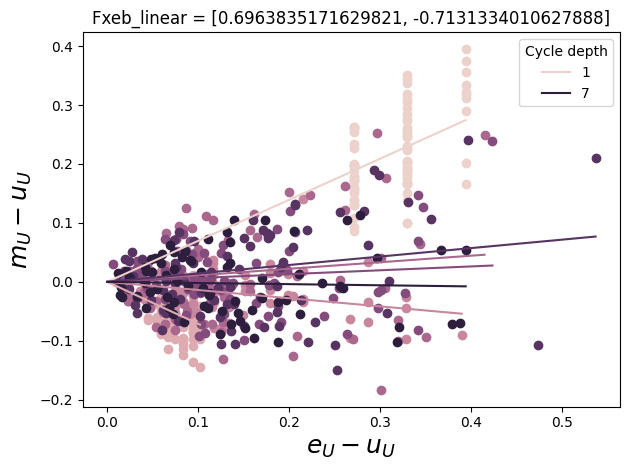

In [134]:
colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.title("Fxeb_linear = %s" %[fids["fidelity"][x] for x in [0, 1]])
plt.tight_layout()


Fit for Google processing data failed
Fit for Log-entropy processing data failed


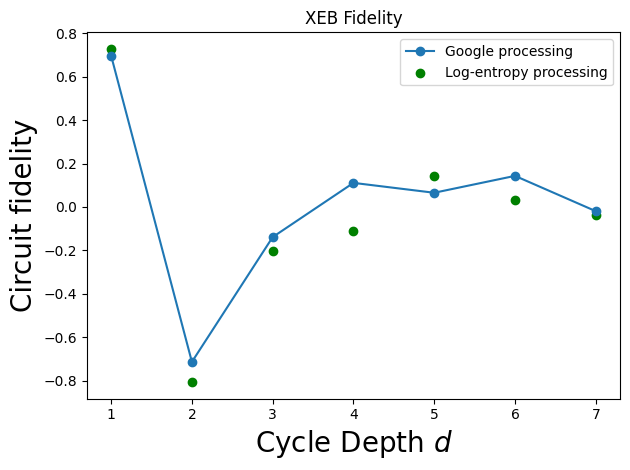

In [135]:
# Fit the data
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

xx = np.linspace(0, fids["depth"].max())
# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    params, covariance = curve_fit(exponential_decay, depths, fids["fidelity"])
    a_fit1, b_fit1, c_fit1 = params
    x = exponential_decay(depths, a_fit1, b_fit1, c_fit1)
    xeb_err_per_cycle1 = 1 - (x[2] - c_fit1) / (x[1] - c_fit1)
    plt.plot(xx, exponential_decay(xx, a_fit1, b_fit1, c_fit1),
         label='Fit (Google processing), err_per_cycle={:.2f}'.format(xeb_err_per_cycle1),
         color='red')
except:
    print("Fit for Google processing data failed")
Fxeb = np.mean(fidelities, axis=0)
try:
    params2, covariance2 = curve_fit(exponential_decay, depths, Fxeb)
    a_fit2, b_fit2, c_fit2 = params2
    x2 = exponential_decay(depths, a_fit2, b_fit2, c_fit2)
    xeb_err_per_cycle2 = 1 - (x2[2] - c_fit2) / (x2[1] - c_fit2)
    plt.plot(xx, exponential_decay(xx, a_fit2, b_fit2, c_fit2),
        label="Fit (Log-entropy processing), err_per_cycle={:.2f}".format(xeb_err_per_cycle2),
        color="green")
    
except:
    print("Fit for Log-entropy processing data failed")
    
    
plt.plot(fids["depth"], fids["fidelity"], marker="o", label="Google processing")

plt.scatter(depths, Fxeb, marker = 'o',
            color='green', label="Log-entropy processing")

plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title("XEB Fidelity")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [32]:
print(a_fit1, b_fit1, c_fit1)
print(a_fit2, b_fit2, c_fit2)
print(xeb_err_per_cycle1, xeb_err_per_cycle2)

NameError: name 'a_fit1' is not defined

In [136]:
print(f"Currently used in the QM XEB example:\n {Fxeb}") # Derived from the fSim paper
print(f'Linear XEB of Google:\n {fids["fidelity"]}') # from Google's Supremacy paper

Currently used in the QM XEB example:
 [ 0.72737652 -0.80599257 -0.20032856 -0.11156985  0.14470229  0.02999965
 -0.03864927]
Linear XEB of Google:
 0    0.696384
1   -0.713133
2   -0.138578
3    0.111007
4    0.065496
5    0.143241
6   -0.019254
Name: fidelity, dtype: float64


In [27]:
print("relative difference", np.abs(fids["fidelity"] - Fxeb))

relative difference 0    0.012264
1    0.072204
Name: fidelity, dtype: float64


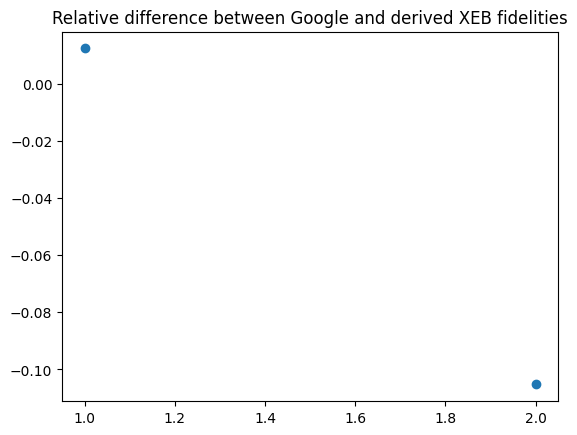

In [28]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")
